# Курсовой проект для курса "Python для Data Science"

## Резюме проекта

#### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

#### Целевая переменная:
Price

#### Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

#### Сроки сдачи:
Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

#### Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

### Описание датасета:
- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры

### Результаты

Анализ датасета показал отсутствие значений ряда признаков, а также аномальные значения признаков у ряда объектов. Отсутствующие значения были расчитаны и дополнены на базе статистических показателей. Строки, аномальные значения которых не удалось интерпретиовать, были удалены (порядка 50 строк), чтобы не вносить шумы в модель.

В ходе работы над проектом были исследованы методы машинного обучения, используемые в данном курсе. Методы линейной регрессии, хоть и показали результат предсказания, удовлетворяющий условию успешности проекта (R2 > 0,6), но были существенно менее эффективны чем модели на основе решающих деревьев. Наилучший полученный результат при применении линейной регрессии R2 = 0.688.

Лучшее качество предсказания получено на основе модели RandomForestRegressor. Эта модель и использовалась на тестовых данных.
Наилучшего разультата удалось добиться после удаления признака LifeSquare, который сильно коррелировал с общей площадью, а также ряда слабозначимых признаков. Кроме того, был создан производный признак на основе DistrictId, который был использован для группировки значений цены по району. Новый производный признак - медианная стоимость кв.м. площади по району.

Результат на тестовых данных после всех преобразований: R2 = 0.75316

![Kaggle Score](kaggle_realestate.png)

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams.update({'font.size': 14})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREPARED_DATASET_PATH = 'housing_train_prepared.csv'
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl'

### Загрузка данных

In [3]:
df_train = pd.read_csv(DATASET_PATH)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [4]:
df_train.shape

(10000, 20)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Видим здесь что 2 признака имеют большое количество отсутствующих значений.

### Обзор количественных признаков

In [6]:
df_num_features = df_train.select_dtypes(include=['float', 'int'])
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


In [7]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обзор категориальных признаков

In [8]:
df_obj_features = df_train.select_dtypes(include='object')
df_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [9]:
df_train['Ecology_2'].value_counts(0)

B    9903
A      97
Name: Ecology_2, dtype: int64

In [10]:
df_train['Ecology_3'].value_counts(0)

B    9725
A     275
Name: Ecology_3, dtype: int64

In [11]:
df_train['Shops_2'].value_counts(0)

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка пропусков

In [12]:
df_train.isna().sum(axis=0)

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Для пропущенных значений LifeSquare сначала найдём соотношение между медианной жилой площадью и медианной общей площадью,
а затем заполним пропущенные значения значением Square, умноженным на найденный коэффициент.

In [13]:
median_lsq_sq_coeff = df_train['LifeSquare'].median() / df_train['Square'].median()
median_lsq_sq_coeff

0.6242466955442353

In [14]:
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = df_train['Square'] * median_lsq_sq_coeff

Для столбца Healthcare_1	имеет смысл заменить пропущенные значения на медианное значение признака

In [15]:
df_train.loc[df_train['Healthcare_1'].isnull(), 'Healthcare_1'] = df_train['Healthcare_1'].median()

In [16]:
df_train.isna().sum(axis=0)

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

### Замена значений категориальных признаков

Учитывая специфику значений признаков Ecology_2, Ecology_3 и Shops_2, имеет смысл заменить буквы на бинарный признак A = 1 и B = 0

In [17]:
df_train.replace({'Ecology_2': {'A': 1, 'B': 0}}, inplace=True)

In [18]:
df_train.replace({'Ecology_3': {'A': 1, 'B': 0}}, inplace=True)

In [19]:
df_train.replace({'Shops_2': {'A': 1, 'B': 0}}, inplace=True)

In [20]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,0,0,33,7976,5,900.0,0,11,0,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,240.0,1,16,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,0,0,34,7759,0,229.0,1,3,0,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,1084.0,0,5,0,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2078.0,2,4,0,150226.531644


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Мы видим, что теперь все признаки у нас цифровые, а также нет пропусков.

### Анализ и обработка выбросов

#### Rooms

Посмотрим количество каждого из значений признака Rooms

In [22]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Выведем строки с "подозрительными" значениями

In [23]:
df_train[((df_train['Rooms'] >= 5) & (df_train['Square'] <= 50)) | (df_train['Rooms'] == 0) | (df_train['Rooms'] >= 6)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,0,0,74,19083,2,900.0,5,15,0,317265.323792
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,0,0,11,3097,0,900.0,0,0,0,268394.744389
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,0,0,1,264,0,900.0,0,1,0,78364.616704
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,0,0,9,1892,0,900.0,0,1,0,302211.260887
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,0,0,66,10573,1,1322.0,3,8,0,229661.964416
2269,7317,27,0.0,41.790881,26.087820,0.0,13,0.0,1977,0.211401,0,0,9,1892,0,900.0,0,1,0,98129.976788
3271,6358,27,5.0,42.003293,26.220417,0.0,5,12.0,1977,0.011654,0,0,4,915,0,900.0,0,0,0,112693.641769
3911,770,28,0.0,49.483501,30.889912,0.0,16,0.0,2015,0.118537,0,0,30,6207,1,1183.0,1,0,0,217009.338463
4366,456,6,0.0,81.491446,50.870766,0.0,4,0.0,1977,0.243205,0,0,5,1564,0,540.0,0,0,0,212864.799112
4431,7594,53,5.0,39.906082,39.394024,1.0,5,1.0,1977,0.049637,0,0,34,7759,0,229.0,1,3,0,206148.845716


Учитывая, что строк с аномальным количеством комнат не много (0,1%) от обучающей выборки, имеет смысл удалить эти строки.

In [24]:
df_train = df_train.drop(df_train[((df_train['Rooms'] >= 5) & (df_train['Square'] <= 50)) | (df_train['Rooms'] == 0)| (df_train['Rooms'] >= 6)].index, axis = 'rows').reset_index(drop=True)

#### LifeSquare

Выведем строки со значением LifeSquare больше 1.96 стандартных отклонения

In [25]:
df_train[(df_train['LifeSquare'] < df_train['LifeSquare'].mean() - df_train['LifeSquare'].std() * 1.96) | (df_train['LifeSquare'] > df_train['LifeSquare'].mean() + df_train['LifeSquare'].std() * 1.96)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
589,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,0,0,6,1437,3,900.0,0,2,0,141780.231857
1978,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,0,1,31,7010,5,4508.0,3,7,0,455264.882666
4254,28,9,2.0,604.705972,377.485705,1.0,17,18.0,1977,0.161532,0,0,25,5648,1,30.0,2,4,0,187717.242538
4320,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,0,0,2,469,0,900.0,0,0,0,217357.492366
4680,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,0,0,26,3889,6,705.0,3,6,0,90470.430830
6965,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,0,0,22,6398,141,1046.0,3,23,0,133529.681562
8425,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,0,0,52,11217,1,2300.0,1,7,0,394253.299978
9896,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,0,0,53,14892,4,900.0,1,4,0,528560.506016


Эти строки эти имеют аномальные значения признаков Square и LifeSquare, поэтому их тоже имеет смысл удалить из обучающей выборки

In [26]:
df_train = df_train.drop(df_train[
    (df_train['LifeSquare'] < df_train['LifeSquare'].mean() - df_train['LifeSquare'].std() * 1.96) |
    (df_train['LifeSquare'] > df_train['LifeSquare'].mean() + df_train['LifeSquare'].std() * 1.96)].index, axis = 'rows').reset_index(drop=True)

#### KitchenSquare

Выведем строки со значением KitchenSquare 1.96 стандартных отклонения от среднего значения

In [27]:
df_train[(df_train['KitchenSquare'] < df_train['KitchenSquare'].mean() - df_train['KitchenSquare'].std() * 1.96) |
   (df_train['KitchenSquare'] > df_train['KitchenSquare'].mean() + df_train['KitchenSquare'].std() * 1.96)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,0,0,39,10418,9,900.0,1,9,0,370148.625285
1062,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,0,0,2,629,1,900.0,0,0,1,108337.484207
1367,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014,0.017647,0,0,2,469,0,900.0,0,0,0,189244.249909
1451,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,0,0,30,5285,0,645.0,6,6,0,438708.707579
2908,12390,72,3.0,97.490674,99.323558,96.0,22,25.0,2019,0.210473,0,0,11,2398,2,1994.0,3,0,0,445074.956552
2961,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,0,0,2,629,1,900.0,0,0,1,315245.521059
4069,6508,23,2.0,67.146049,33.959154,63.0,5,17.0,2019,0.034656,0,0,0,168,0,900.0,0,0,0,193130.585871
4637,12552,58,3.0,116.405693,113.109653,112.0,3,3.0,2016,0.437885,0,0,23,5735,3,1084.0,0,5,0,296165.936689
5133,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,0,0,21,5731,0,900.0,1,0,0,160488.033165
6223,4966,96,3.0,78.445675,47.146757,75.0,9,12.0,1977,0.041116,0,0,53,14892,4,900.0,1,4,0,290354.484070


Эти строки также являются аномальными, т.к. KitchenSquare равна или сильно превышает общую площадь Square. Удалим их.

In [28]:
df_train = df_train.drop(df_train[(df_train['KitchenSquare'] < df_train['KitchenSquare'].mean() - df_train['KitchenSquare'].std() * 1.96) |
   (df_train['KitchenSquare'] > df_train['KitchenSquare'].mean() + df_train['KitchenSquare'].std() * 1.96)].index, axis = 'rows').reset_index(drop=True)

#### HouseYear

Выведем дома, у которых год постройки > 2020

In [29]:
df_train[df_train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1489,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,0,0,30,6141,10,262.0,3,6,0,254084.534396
4172,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,0,0,25,4756,16,2857.0,5,8,0,243028.603096


Заменим значения '20052011' на 2008 (среднее между 2005-2011) и 4068 на 1968

In [30]:
df_train.replace({'HouseYear': {20052011: 2008, 4968: 1968}}, inplace=True)

#### Square

Выведем квартиры с общей площадью меньше 10 (что маловероятно), а также где общая площадь меньше жилой и разница более 10м2

In [31]:
df_train[(df_train['Square'] < 10) | (df_train['Square'] + 10 < df_train['LifeSquare'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,0,0,43,8429,3,900.0,3,9,0,412511.088764
1312,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,0,0,4,915,0,900.0,0,0,0,107604.269441
1600,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,0,0,5,1564,0,540.0,0,0,0,137597.601458
3265,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,0,0,9,1892,0,900.0,0,1,0,97560.720383
3398,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,0,0,16,3433,4,2643.0,4,5,0,369472.403061
4876,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,0,0,9,1892,0,900.0,0,1,0,161379.067034
6305,8961,27,1.0,33.398983,164.153360,6.0,3,5.0,1965,0.211401,0,0,9,1892,0,900.0,0,1,0,104891.073757
6365,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,0,0,1,264,0,900.0,0,1,0,181434.825589
8001,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,0,0,1,264,0,900.0,0,1,0,237716.681261
8254,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,0,0,53,13670,4,900.0,1,11,0,458378.777006


Эти данные тоже стоит признать аномальными и удалить

In [32]:
df_train = df_train.drop(df_train[(df_train['Square'] < 10) | (df_train['Square'] + 10 < df_train['LifeSquare'])].index, axis = 'rows').reset_index(drop=True)

In [33]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000,9953.000000
mean,8379.963127,50.452828,1.887170,56.144381,36.266465,5.792023,8.524967,12.622325,1984.814729,0.118914,0.009746,0.027529,24.708530,5355.741284,8.056264,1026.486989,1.320004,4.234703,0.082689,214014.281257
std,4858.619216,43.639231,0.809428,18.786098,16.340312,4.368426,5.231921,6.761819,18.395011,0.119126,0.098244,0.163628,17.521804,4003.687596,23.846248,746.970218,1.492673,4.807004,0.275425,92670.552178
min,0.000000,0.000000,1.000000,13.784865,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4166.000000,20.000000,1.000000,41.784525,24.358538,1.000000,4.000000,9.000000,1974.000000,0.017647,0.000000,0.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,0.000000,153912.044504
50%,8393.000000,36.000000,2.000000,52.513850,33.275668,6.000000,7.000000,13.000000,1977.000000,0.075424,0.000000,0.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,0.000000,192198.448321
75%,12590.000000,75.000000,2.000000,65.875102,44.877071,9.000000,12.000000,17.000000,2001.000000,0.195781,0.000000,0.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,0.000000,249063.801948
max,16798.000000,209.000000,5.000000,198.930182,174.837082,62.000000,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


### Графический анализ данных

#### Анализ целевой переменной

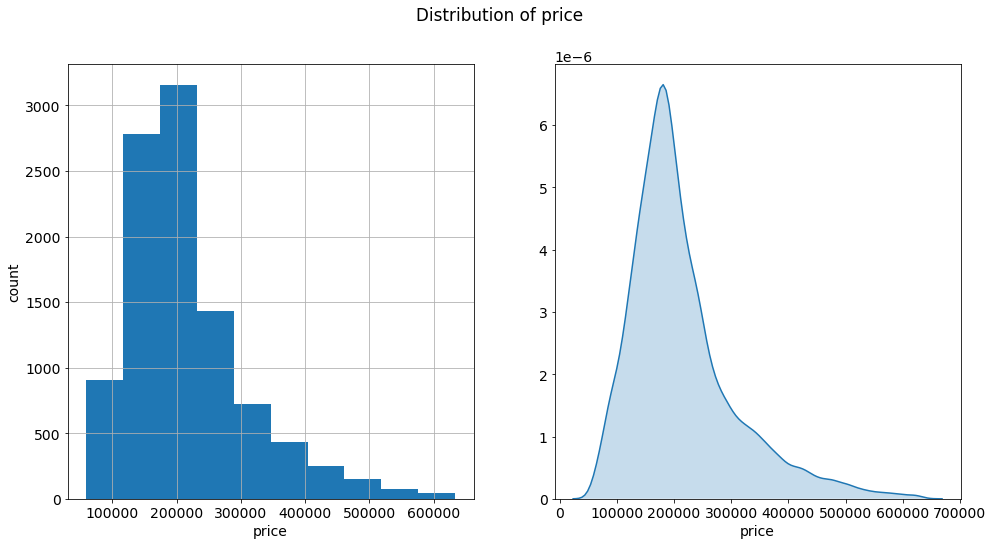

In [34]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
df_train['Price'].hist()
plt.xlabel('price')
plt.ylabel('count')

plt.subplot(122)
sns.kdeplot(df_train['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Distribution of price')
plt.show()

Распределение выглядит унимодальным без заметных выбросов.  
Посмотрим основные величины описательной статистики.

In [35]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()

target_mean, target_median

(214014.28, 192198.44832082995)

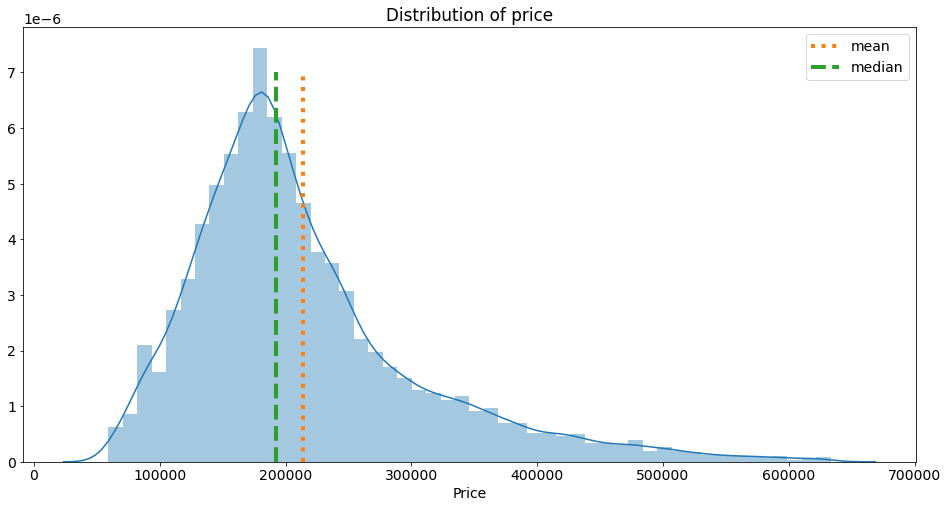

In [36]:
plt.figure(figsize=(16, 8))

sns.distplot(df_train['Price'])

y = np.linspace(0, 7e-6, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.title('Distribution of price')
plt.legend()
plt.show()

### Анализ взаимосвязи признаков

Обновим перечень цифровых признаков и построим матрицу корреляции в виде тепловой карты

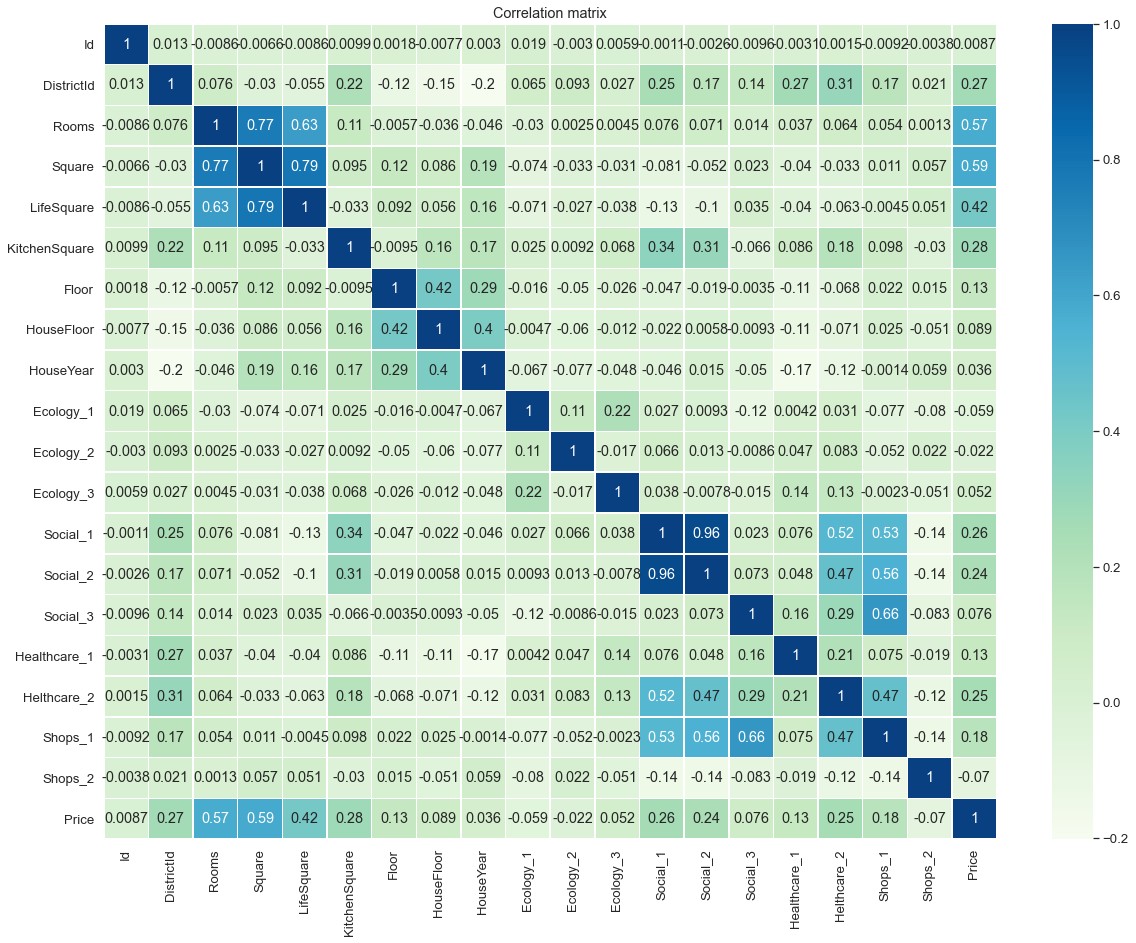

In [37]:
plt.figure(figsize=(20, 15))

sns.set(font_scale=1.2)
sns.heatmap(df_train.corr(), annot=True, linewidths=0.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор лишних признаков

Удалим признак Id как незначимый, а также LifeSquare, т.к. он сильно коррелирует с Square и по сути является избыточным.

In [38]:
df_train = df_train.drop(['Id', 'LifeSquare'], axis = 'columns')

В связи с тем, что мы не знаем каким образом выбирался DistrictId, заменим значения этого признака на медианную цену кв.м по району.

In [39]:
df_train['Price_sq_meter'] = df_train['Price'] / df_train['Square']

In [40]:
median_price_by_id = df_train.groupby('DistrictId')[['Price_sq_meter']].median().reset_index()

In [41]:
df_train = pd.merge(df_train, median_price_by_id, how='left', on='DistrictId')

In [42]:
df_train.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_sq_meter_x,Price_sq_meter_y
0,35,2.0,47.981561,6.0,7,9.0,1969,0.089040,0,0,33,7976,5,900.0,0,11,0,184966.930730,3854.958571,4358.274853
1,41,3.0,65.683640,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,240.0,1,16,0,300009.450063,4567.491245,4437.304072
2,53,2.0,44.947953,0.0,8,12.0,1968,0.049637,0,0,34,7759,0,229.0,1,3,0,220925.908524,4915.149522,4832.085356
3,58,2.0,53.352981,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,1084.0,0,5,0,175616.227217,3291.591637,2963.980646
4,99,1.0,39.649192,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2078.0,2,4,0,150226.531644,3788.892642,3994.531770


In [43]:
df_train = df_train.drop(['DistrictId', 'Price_sq_meter_x'], axis='columns')

### Сохраняем подготовленный датасет

In [44]:
df_train.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

In [45]:
df_train = pd.read_csv(PREPARED_DATASET_PATH)

### Отбор признаков

In [46]:
df_train.columns.tolist()

['Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Price_sq_meter_y']

In [47]:
feature_names = ['Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price_sq_meter_y']
target_name = ['Price']

### Разбиение выборки на обучающий и валидационный наборы

In [48]:
X = df_train[feature_names]
y = df_train[target_name]

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

### Построение модели машинного обучения

#### Скрипт для отображения оценки качества модели

In [50]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" +
          str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

#### RandomForrestRegressor

In [51]:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': np.arange(10, 15),
}

gs = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [52]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([10, 11, 12, 13, 14]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [150, 200, 250]},
             scoring='r2')

In [53]:
gs.best_params_

{'max_depth': 14, 'max_features': 'log2', 'n_estimators': 150}

In [54]:
rf_model = RandomForestRegressor(max_depth=14, max_features='log2', n_estimators=150)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, max_features='log2', n_estimators=150)

R2:	0.934
MAE:	15211.401
MSE:	563379169.899


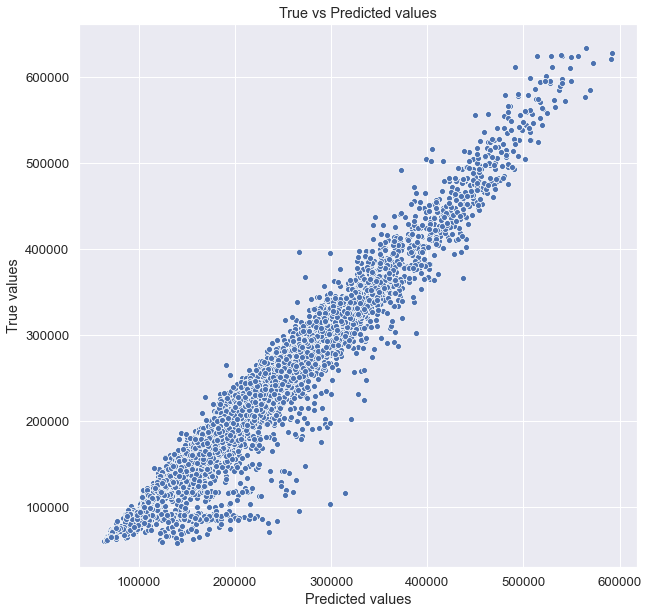

In [55]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train.values.flatten(), y_train_preds.flatten())

R2:	0.769
MAE:	26405.268
MSE:	1985736985.383


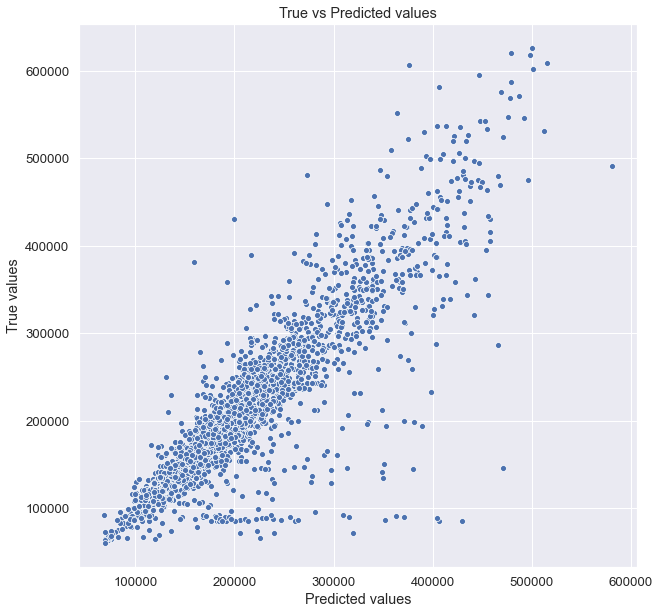

In [56]:
y_valid_preds = rf_model.predict(X_valid)
evaluate_preds(y_valid.values.flatten(), y_valid_preds.flatten())

Посмотрим важность признаков.

In [57]:
f_importance = pd.DataFrame()
f_importance['Name'] = feature_names
f_importance['Values'] = rf_model.feature_importances_
f_importance.sort_values('Values', ascending=False).reset_index(drop=True)

,Name,Values
0,Square,0.279572
1,Price_sq_meter_y,0.171241
2,Rooms,0.152596
3,Social_2,0.063481
4,KitchenSquare,0.053788
5,Social_1,0.048065
6,HouseYear,0.047143
7,Social_3,0.043027
8,HouseFloor,0.030268
9,Floor,0.028122


Отбросим признаки со значимостью ниже 0.02 и обучим модель заново.

In [58]:
feature_names = ['Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Shops_1',
 'Price_sq_meter_y']
target_name = ['Price']

In [59]:
X = df_train[feature_names]
y = df_train[target_name]

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [62]:
rf_model = RandomForestRegressor(max_depth=14, max_features='log2', n_estimators=150)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, max_features='log2', n_estimators=150)

R2:	0.937
MAE:	14945.124
MSE:	542250844.897


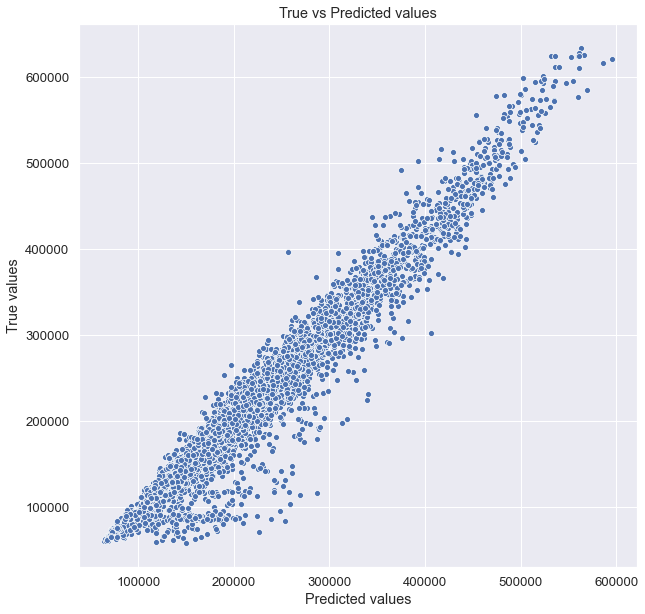

In [63]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train.values.flatten(), y_train_preds.flatten())

R2:	0.772
MAE:	26235.083
MSE:	1963077704.893


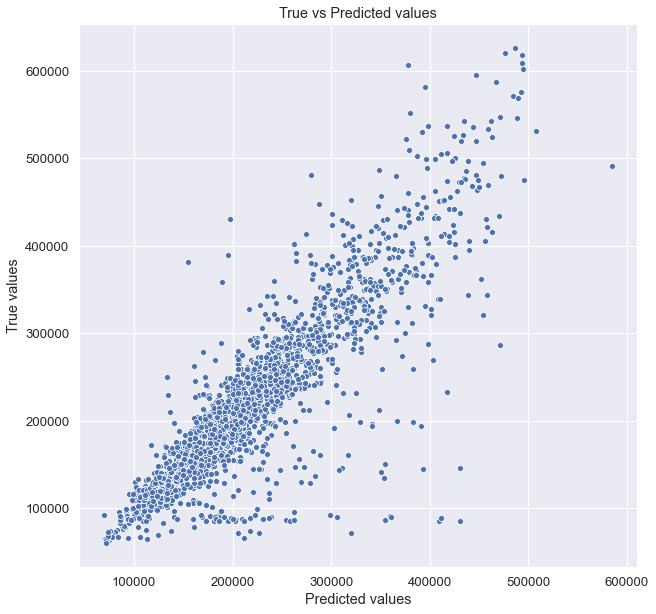

In [64]:
y_valid_preds = rf_model.predict(X_valid)
evaluate_preds(y_valid.values.flatten(), y_valid_preds.flatten())

Переобучим её на полном наборе данных.

In [65]:
final_model = rf_model.fit(X, y)

### Сохранение модели

In [66]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [67]:
with open(MODEL_FILE_PATH, 'rb') as file:
    model_load=pickle.load(file)

### Проверка работы модели на тестовых данных

Загрузим тестовый набор.

In [68]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [69]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Оформим все предварительные манипуляции по обработке датасета в отдельную функцию.

In [71]:
# Удаляем пропуски
median_lsq_sq_coeff = df_test['LifeSquare'].median() / df_test['Square'].median()
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = df_test['Square'] * median_lsq_sq_coeff
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

In [72]:
# Заменяем категориальные признаки на бинарные
df_test.replace({'Ecology_2': {'A': 1, 'B': 0}}, inplace=True)
df_test.replace({'Ecology_3': {'A': 1, 'B': 0}}, inplace=True)
df_test.replace({'Shops_2': {'A': 1, 'B': 0}}, inplace=True)

In [73]:
# Заменяем DistrictId на медианную цену по району
df_test = pd.merge(df_test, median_price_by_id, how='left', on='DistrictId')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price_sq_meter
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,0,0,11,2748,1,900.0,0,0,0,2963.980646
1,15856,74,2.0,69.263183,43.092188,1.0,6,1.0,1977,0.075779,0,0,6,1437,3,900.0,0,2,0,3319.318045
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,0,0,30,7538,87,4702.0,5,5,0,8645.171143
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,0,0,23,4583,3,900.0,3,3,0,4181.963615
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,0,0,2,629,1,900.0,0,0,1,2762.513283


In [74]:
df_test = df_test.drop('DistrictId', axis='columns')
df_test['Price_sq_meter'] = df_test['Price_sq_meter'].fillna(df_test['Price_sq_meter'].median())

In [75]:
df_test.isnull().sum()

Id                0
Rooms             0
Square            0
LifeSquare        0
KitchenSquare     0
Floor             0
HouseFloor        0
HouseYear         0
Ecology_1         0
Ecology_2         0
Ecology_3         0
Social_1          0
Social_2          0
Social_3          0
Healthcare_1      0
Helthcare_2       0
Shops_1           0
Shops_2           0
Price_sq_meter    0
dtype: int64

In [76]:
y_test_preds = model_load.predict(df_test.drop(['Id', 'LifeSquare', 'Ecology_2','Ecology_3', 'Healthcare_1', 'Helthcare_2', 'Shops_2'], axis = 'columns'))

In [77]:
y_test_preds = pd.DataFrame(y_test_preds, columns=['Price'])

In [78]:
y_test_preds.insert(0, 'Id', df_test['Id'])

In [79]:
y_test_preds.to_csv('AArzanov_predictions.csv', index=False, encoding='utf-8')